# PolygonRNN++ Demo
This demo will illustrates step by step how to run PolygonRNN++ on a sample image crop.

In [1]:
#imports
import tensorflow as tf
import numpy as np
from PolygonModel import PolygonModel
from EvalNet import EvalNet
from GGNNPolyModel import GGNNPolygonModel
import utils
from poly_utils import vis_polys
import skimage.io as io

/Users/t0r01c5/opt/anaconda3/envs/python3-6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/t0r01c5/opt/anaconda3/envs/python3-6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/t0r01c5/opt/anaconda3/envs/python3-6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/t0r01c5/opt/

In [2]:
!pwd

/Users/t0r01c5/polyrnn-pp/src


In [3]:
#External PATHS
PolyRNN_metagraph='../models/poly/polygonplusplus.ckpt.meta'
PolyRNN_checkpoint='../models/poly/polygonplusplus.ckpt'
EvalNet_checkpoint='../models/evalnet/evalnet.ckpt'
GGNN_metagraph='../models/ggnn/ggnn.ckpt.meta'
GGNN_checkpoint='../models/ggnn/ggnn.ckpt'



In [4]:
#Const
_BATCH_SIZE=1
_FIRST_TOP_K = 6

In [5]:
# Creating the graphs
evalGraph = tf.Graph()
polyGraph = tf.Graph()
ggnnGraph = tf.Graph()

In [6]:
#Initializing and restoring the evaluator net.
with evalGraph.as_default():
    with tf.variable_scope("discriminator_network"):
        evaluator = EvalNet(_BATCH_SIZE)
        evaluator.build_graph()
    saver = tf.train.Saver()

    # Start session
    evalSess = tf.Session(config=tf.ConfigProto(
        allow_soft_placement=True
    ), graph=evalGraph)
    saver.restore(evalSess, EvalNet_checkpoint)

INFO:tensorflow:Restoring parameters from ../models/evalnet/evalnet.ckpt


In [7]:
#Initializing and restoring PolyRNN++
model = PolygonModel(PolyRNN_metagraph, polyGraph)
model.register_eval_fn(lambda input_: evaluator.do_test(evalSess, input_))
polySess = tf.Session(config=tf.ConfigProto(
    allow_soft_placement=True
), graph=polyGraph)
model.saver.restore(polySess, PolyRNN_checkpoint)

INFO:tensorflow:Restoring parameters from ../models/poly/polygonplusplus.ckpt


In [8]:
#Initializing and restoring GGNN
ggnnGraph = tf.Graph()
ggnnModel = GGNNPolygonModel(GGNN_metagraph, ggnnGraph)
ggnnSess = tf.Session(config=tf.ConfigProto(
    allow_soft_placement=True
), graph=ggnnGraph)

ggnnModel.saver.restore(ggnnSess,GGNN_checkpoint)

INFO:tensorflow:Restoring parameters from ../models/ggnn/ggnn.ckpt


In [9]:
from PIL import Image
im = Image.open('image.png')
width, height = im.size
print(width, height)

208 79


In [10]:
newsize = (224, 224)
im1 = im.resize(newsize)
im1 = im1.save("image_resize.png")

In [11]:
#INPUT IMG CROP (224x224x3) -> object should be centered
#crop_path='image.png'
crop_path = 'image_resize.png'

In [12]:
#Testing
image_np = io.imread(crop_path)
image_np = image_np[:,:,:3]
image_np = np.expand_dims(image_np, axis=0)
preds = [model.do_test(polySess, image_np, top_k) for top_k in range(_FIRST_TOP_K)]

# sort predictions based on the eval score to pick the best.
preds = sorted(preds, key=lambda x: x['scores'][0], reverse=True)

[None, None, None, None, None, None]

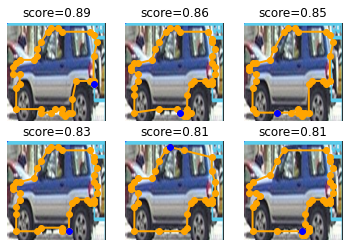

In [13]:
#Visualizing TOP_K and scores
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,3)
axes=np.array(axes).flatten()
[vis_polys(axes[i], image_np[0], np.array(pred['polys'][0]), title='score=%.2f' % pred['scores'][0]) for i,pred in enumerate(preds)]

In [14]:
bestPoly = preds[0]['polys'][0]
feature_indexs, poly, mask = utils.preprocess_ggnn_input(bestPoly)

In [15]:
#Let's run GGNN now on the bestPoly
bestPoly = preds[0]['polys'][0]
feature_indexs, poly, mask = utils.preprocess_ggnn_input(bestPoly)
preds_gnn = ggnnModel.do_test(ggnnSess, image_np, feature_indexs, poly, mask)
refinedPoly=preds_gnn['polys_ggnn']

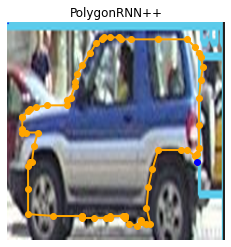

In [16]:
#Visualize the final prediction
fig, ax = plt.subplots(1,1)
vis_polys(ax,image_np[0],refinedPoly[0], title='PolygonRNN++')

In [18]:
image_np[0]

array([[[ 92, 203, 234],
        [ 92, 203, 234],
        [ 92, 203, 234],
        ...,
        [ 85, 182, 209],
        [ 37,  33,  31],
        [ 34,  34,  34]],

       [[ 92, 203, 234],
        [ 92, 203, 234],
        [ 92, 203, 234],
        ...,
        [ 85, 182, 209],
        [ 37,  33,  31],
        [ 34,  34,  34]],

       [[ 92, 203, 234],
        [ 92, 203, 234],
        [ 92, 203, 234],
        ...,
        [ 85, 182, 209],
        [ 37,  33,  31],
        [ 34,  34,  34]],

       ...,

       [[254, 250, 247],
        [253, 249, 246],
        [251, 246, 242],
        ...,
        [ 77, 180, 209],
        [ 37,  33,  31],
        [ 35,  35,  35]],

       [[252, 247, 244],
        [251, 246, 242],
        [255, 251, 246],
        ...,
        [ 77, 180, 209],
        [ 37,  33,  31],
        [ 35,  35,  35]],

       [[252, 246, 243],
        [251, 245, 241],
        [255, 253, 247],
        ...,
        [ 77, 180, 209],
        [ 37,  33,  31],
        [ 35,  35,  35]]

In [19]:
from predict_poly import polygon_detection

In [21]:
image,poly = polygon_detection('image.png')

Pretrained model is loaded
INFO:tensorflow:Restoring parameters from ../models/evalnet/evalnet.ckpt
INFO:tensorflow:Restoring parameters from ../models/poly/polygonplusplus.ckpt
INFO:tensorflow:Restoring parameters from ../models/ggnn/ggnn.ckpt
Model is initialized
image loaded successfully
predictions sorted based on eval score


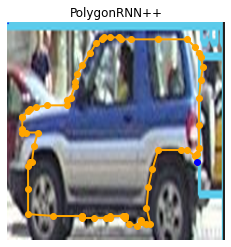

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
vis_polys(ax,image,poly, title='PolygonRNN++')

In [23]:
image

array([[[ 92, 203, 234],
        [ 92, 203, 234],
        [ 92, 203, 234],
        ...,
        [ 85, 182, 209],
        [ 37,  33,  31],
        [ 34,  34,  34]],

       [[ 92, 203, 234],
        [ 92, 203, 234],
        [ 92, 203, 234],
        ...,
        [ 85, 182, 209],
        [ 37,  33,  31],
        [ 34,  34,  34]],

       [[ 92, 203, 234],
        [ 92, 203, 234],
        [ 92, 203, 234],
        ...,
        [ 85, 182, 209],
        [ 37,  33,  31],
        [ 34,  34,  34]],

       ...,

       [[254, 250, 247],
        [253, 249, 246],
        [251, 246, 242],
        ...,
        [ 77, 180, 209],
        [ 37,  33,  31],
        [ 35,  35,  35]],

       [[252, 247, 244],
        [251, 246, 242],
        [255, 251, 246],
        ...,
        [ 77, 180, 209],
        [ 37,  33,  31],
        [ 35,  35,  35]],

       [[252, 246, 243],
        [251, 245, 241],
        [255, 253, 247],
        ...,
        [ 77, 180, 209],
        [ 37,  33,  31],
        [ 35,  35,  35]]

In [24]:
poly

array([[0.87053573, 0.63839287],
       [0.87053573, 0.6026786 ],
       [0.87946427, 0.57589287],
       [0.87946427, 0.46875   ],
       [0.87946427, 0.34375   ],
       [0.88839287, 0.26339287],
       [0.8973214 , 0.20089285],
       [0.88839287, 0.15625   ],
       [0.87946427, 0.13839285],
       [0.86160713, 0.11160714],
       [0.82589287, 0.07589286],
       [0.69196427, 0.07589286],
       [0.56696427, 0.07589286],
       [0.5223214 , 0.07589286],
       [0.51339287, 0.06696428],
       [0.46875   , 0.06696428],
       [0.4419643 , 0.06696428],
       [0.4330357 , 0.07589286],
       [0.40625   , 0.09375   ],
       [0.3794643 , 0.13839285],
       [0.34375   , 0.19196428],
       [0.3169643 , 0.23660715],
       [0.3080357 , 0.27232143],
       [0.3080357 , 0.29017857],
       [0.29017857, 0.34375   ],
       [0.27232143, 0.35267857],
       [0.27232143, 0.3794643 ],
       [0.18303572, 0.3794643 ],
       [0.12946428, 0.38839287],
       [0.10267857, 0.39732143],
       [0.

## vis_polys

In [25]:
def vis_polys(ax, img, poly, title=''):
    #height and width of the image
    h, w = img.shape[:2]
    ax.imshow(img, aspect='equal')
    patch_poly = patches.Polygon(poly, alpha=0.6, color='blue')
    ax.add_patch(patch_poly)
    poly = np.append(poly, [poly[0, :]], axis=0)
    #
    ax.plot(poly[:, 0] * w, poly[:, 1] * h, '-o', linewidth=2, color='orange')
    # first point different color
    ax.plot(poly[0, 0] * w, poly[0, 1] * h, '-o', linewidth=3, color='blue')
    ax.set_title(title)
    ax.axis('off')

In [26]:
img = image
poly=poly

In [33]:
img.shape

(224, 224, 3)

In [34]:
img.shape[:2]

(224, 224)

In [35]:
h, w = img.shape[:2]

In [36]:
ax.imshow(img, aspect='equal')

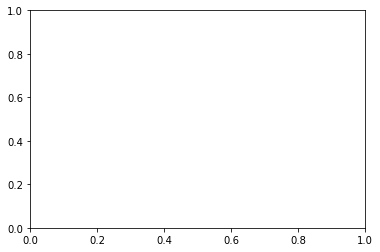

In [37]:
fig, ax = plt.subplots(1,1)

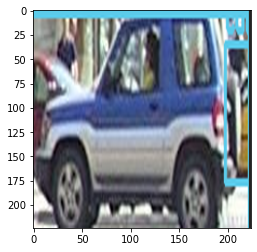

In [40]:
plt.imshow(img, aspect='equal')

In [46]:
import matplotlib.patches as patches
patch_poly = patches.Polygon(poly, alpha=0.6, color='blue')

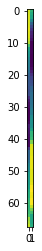

In [47]:
plt.imshow(poly, aspect='equal')

In [48]:
poly[0, :]

array([0.87053573, 0.63839287], dtype=float32)